In [1]:
import pickle
import torch

import gradoptics as optics
from gradoptics.integrator import HierarchicalSamplingIntegrator
from ml.siren import Siren

import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

/projects/p30957/envs/pytorch-1.11-py38-alt-2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


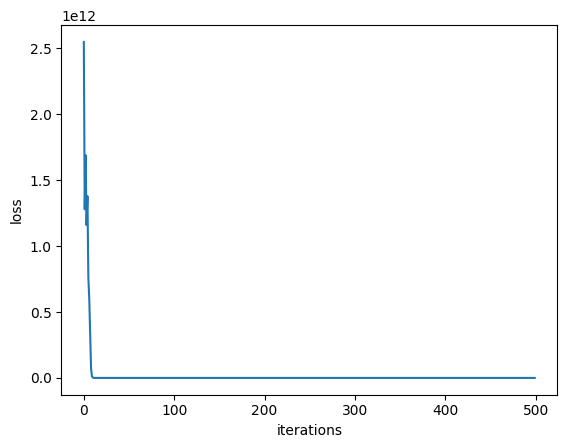

In [2]:
import pandas as pd

loss = pd.read_csv('loss_pixel_size_same.csv')
plt.plot(loss[0:500],'-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [3]:
device = 'cuda'

in_features = 3
hidden_features = 256
hidden_layers = 3
out_features = 1

model = Siren(in_features, hidden_features, hidden_layers, out_features,
              outermost_linear=True, outermost_linear_activation=nn.ReLU()).double().to(device)

f_pattern = 'model_*_NW_MOT_all_cameras_long.pt'

from glob import glob
n_checkpoints = len(glob(f_pattern))
last = (n_checkpoints-1)*500

last = 1000

with torch.no_grad():
    fname = f_pattern.replace("*", "{last}").format(last=last)
    model.load_state_dict(torch.load(fname))

In [4]:
scene_objects = pickle.load(open("NW_mot_scene_components.pkl", "rb"))
data_intensities_all = pickle.load(open("NW_mot_images.pkl", "rb"))

In [5]:
rad = 0.03
obj_pos = (0, 0, 0)

light_source = optics.LightSourceFromNeuralNet(model, optics.BoundingSphere(radii=rad, 
                                                                     xc=obj_pos[0], yc=obj_pos[1], zc=obj_pos[2]),
                                        rad=rad, x_pos=obj_pos[0], y_pos=obj_pos[1], z_pos=obj_pos[2])
scene_train = optics.Scene(light_source)

for obj in scene_objects:
    scene_train.add_object(obj)

In [6]:
from gradoptics.integrator import HierarchicalSamplingIntegrator
integrator = HierarchicalSamplingIntegrator(64, 64, stratify = False)

## Render image at sensors

In [7]:
pixel_batch = 200000//40
camera_intensities_all = []
with torch.no_grad():
    for i,obj in enumerate(scene_objects):
        if type(obj) == optics.Sensor:
            sensor = scene_objects[i]
            lens = scene_objects[i+1]
            
            # Define pixel indices
            idxs = torch.cartesian_prod(torch.arange(sensor.resolution[0]//2, -sensor.resolution[0]//2, -1), 
                                torch.arange(sensor.resolution[1]//2, -sensor.resolution[1]//2, -1))
        
            pix_x, pix_y = idxs.T
        
            # Batch over them for rendering -- I used a large GPU
            batch_pix_x = pix_x.split(pixel_batch)
            batch_pix_y = pix_y.split(pixel_batch)
        
            intensities_all = []
            
            device = 'cuda'
            lens_pos = scene_objects[i+1].transform.transform[:-1, -1].to(device)       
            
            for j in tqdm(range(len(batch_pix_x))):
                nb_pixels = len(batch_pix_x[j])
                            
                origins = torch.zeros((nb_pixels,3),device = device,dtype = torch.float64)
                origins[:,0] = (batch_pix_x[j].to(device))* sensor.pixel_size[0]
                origins[:,1] = (batch_pix_y[j].to(device))* sensor.pixel_size[1]
                origins = sensor.c2w.apply_transform_(origins.reshape(-1, 3)).reshape((nb_pixels, 3))
                pA = 1 / (sensor.resolution[0] * sensor.pixel_size[0] * sensor.resolution[1] * sensor.pixel_size[1])         
                
                directions = lens_pos - origins
                directions = directions/torch.norm(directions, dim=1, keepdim=True)  
               
                outgoing_rays = optics.Rays(origins, directions, device='cuda')
                intensities_all.append(optics.backward_ray_tracing(outgoing_rays,scene_train, scene_train.light_source,integrator, max_iterations=6))
        
            camera_intensities = torch.cat(intensities_all).reshape(sensor.resolution).cpu()
            camera_intensities_all.append(camera_intensities.clone())

100%|██████████████████████████████████████████████████| 147/147 [00:19<00:00,  7.63it/s]


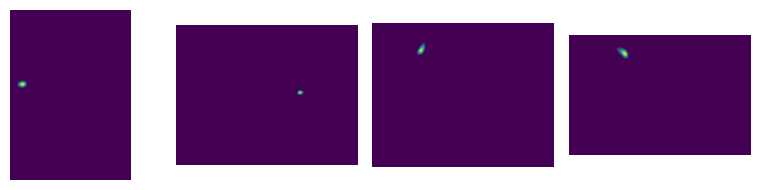

In [8]:
%matplotlib inline
fig, ax = plt.subplots(1,4, figsize=(8, 2))
for i in range(len(camera_intensities_all)):
    im = ax[i].imshow(camera_intensities_all[i].cpu().T)
    ax[i].axis('off')
plt.tight_layout()

## World-space density distribution

In [9]:
n_side = 100
bound = 1/np.sqrt(3.)
grid = torch.cartesian_prod(torch.linspace(-bound, bound, n_side),
                            torch.linspace(-bound, bound, n_side),
                            torch.linspace(-bound, bound, n_side)).cuda().double()

batch_size = 100**3
with torch.no_grad():
    fname = f_pattern.replace("*", "{last}").format(last=last)
    model.load_state_dict(torch.load(fname))
    densities = []
    grid_batches = grid.split(batch_size)
    for grid_batch in tqdm(grid_batches):
        densities.append(model(grid_batch)[0].cpu())
    densities = torch.cat(densities).reshape((n_side, n_side, n_side))

100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


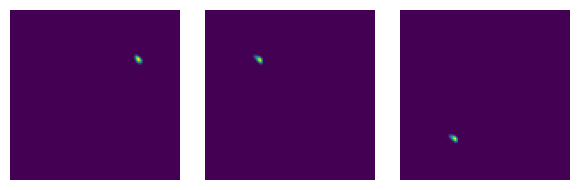

In [10]:
fig,ax = plt.subplots(1,3,figsize = (6,2))
for i in range(3):
    ax[i].imshow(densities.sum(dim=i).T)
    ax[i].axis('off')
plt.tight_layout()

## training animation

In [11]:
all_densities = []
with torch.no_grad():
    for n_iter in tqdm(np.arange(0, n_checkpoints*500, 500)):
        model.load_state_dict(torch.load(f_pattern.replace("*", "{n_iter}").format(n_iter=n_iter)))
        densities = model(grid)[0].reshape((n_side, n_side, n_side)).cpu()
        all_densities.append(densities.clone())

%matplotlib notebook
from celluloid import Camera
fig, ax = plt.subplots(1, 4, figsize=(8,4))
camera = Camera(fig)

for i in range(len(all_densities)):
    ax[0].text(0.9, 0.5, "Reconstructed", ha='right', fontsize=14)
    ax[0].axis('off')

    #ax[1, 0].text(0.9, 0.5, "True", ha='right', fontsize=14)
#ax[1, 0].axis('off')

    ax[1].imshow(all_densities[i].sum(dim=0).T, origin="lower")
    ax[1].set_title('Sum x', fontsize=14)
    ax[1].axis('off')

    ax[2].imshow(all_densities[i].detach().sum(dim=1).T, origin="lower")
    ax[2].set_title('Sum y', fontsize=14)
    ax[2].axis('off')

    ax[3].imshow(all_densities[i].sum(dim=2).T, origin="lower")
    ax[3].set_title('Sum z', fontsize=14)
    ax[3].axis('off')
    
    plt.tight_layout()
    camera.snap()
'''
    ax[1, 1].imshow(pdf_vals.sum(dim=0).T, origin="lower")
    ax[1, 1].axis('off')

    ax[1, 2].imshow(pdf_vals.sum(dim=1).T, origin="lower")
    ax[1, 2].axis('off')

    ax[1, 3].imshow(pdf_vals.sum(dim=2).T, origin="lower")
    ax[1, 3].axis('off')
'''


animation = camera.animate()
save_name = fname.replace('.pt', '.gif').replace('model', 'training_rand')
animation.save(save_name)

100%|██████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.17it/s]


<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.
